In [1]:
# Recreate figure analyses and plots - does not require caveCLIENT permissions

In [2]:
# import packages
import pandas as pd
from matplotlib import pyplot,patches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cmocean
# import ptitprince as pt


In [93]:
# import dataframe
multi_df = pd.read_pickle('pkls/preMN_to_MN_wing_v604.pkl')
multi_df_2 = pd.read_pickle('pkls/preMN_to_MN_wing_v604_given_to_tony.pkl')
multi_df_3 = pd.read_pickle('pkls/preMN_to_MN_wing_0106.pkl')
multi_df_4 = pd.read_pickle('pkls/preMN_to_MN_wing_v604_multi_df.pkl')
properties_df = pd.read_pickle('pkls/wingMN_properties_v604.pkl')


In [97]:
multi_df_3.shape

(1779, 29)

In [4]:
# multi_df is already organized. Cosine similarity metrics are (re-)calculated below

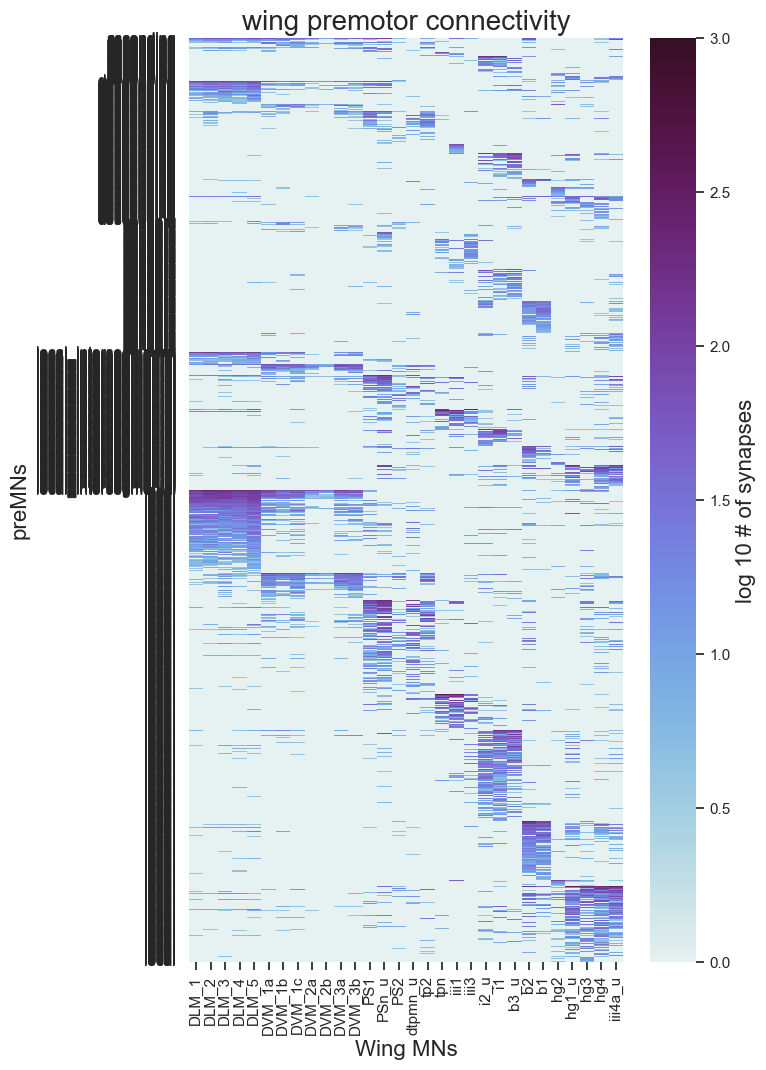

In [5]:
# plotting code for wing premotor connectome
source = multi_df

fig = plt.figure(1, figsize = [7,12])
sns.set(font_scale= 1)
cmap = cmocean.cm.dense

log_values = np.log10(source +1)
pmn_ids = source.index.get_level_values(level='cell_class').to_list()
mn_ids = source.columns.to_list()
ax = sns.heatmap(log_values, vmin = 0, vmax = 3, xticklabels=mn_ids, yticklabels=pmn_ids, cmap = cmap)

ax.xaxis.set_ticks_position('bottom')
cbar = ax.collections[0].colorbar
plt.title('wing premotor connectivity', size = 20)
cbar.set_label(label = 'log 10 # of synapses', size=16)
plt.xlabel('Wing MNs', size = 16)
plt.ylabel('preMNs', size = 16)

plt.show()

In [6]:
# plot proportions from each cell class
df_by_cell_class = multi_df.groupby(level='cell_class').sum().T.rename_axis('MN_label').reset_index()

dict_syn = dict(zip(properties_df.MN_label, properties_df.synapses_include_fragments))

df_by_cell_class['synapses_with_fragments'] = df_by_cell_class.MN_label.map(dict_syn)

# dataframe of proportions for plotting
df_by_cell_class_proportions = df_by_cell_class[['local','local_intersegmental','descending','sensory','ascending']].divide(df_by_cell_class.synapses_with_fragments, axis=0)


In [7]:
df_by_cell_class_proportions.index = df_by_cell_class['MN_label']
df_by_cell_class_proportions['fragment'] = df_by_cell_class_proportions.apply(
    lambda x: 1 - (x['ascending'] + x['descending'] + x['sensory'] + x['local_intersegmental'] + x['local']), axis=1)


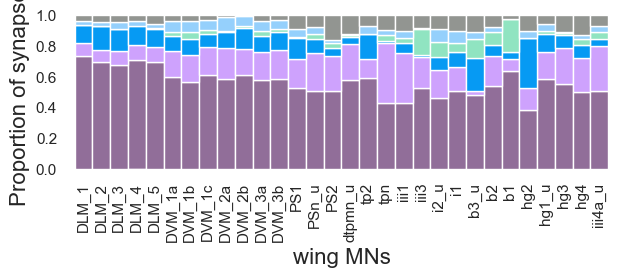

In [8]:
source = df_by_cell_class_proportions

colors_cell_class = ["#916e99","#cea2fd","#069af3","#90e4c1","#95d0fc","#929591", "#650021"]
cmap_cell_class = sns.set_palette(sns.color_palette(colors_cell_class))

#create stacked bar chart
p = source.plot(kind='bar', stacked=True, width = 1, legend = False, cmap = cmap_cell_class, figsize=(7, 2)) 

p.set_ylabel("Proportion of synapses",fontsize = 16)
p.set(ylim=(0, 1))
p.set_xlabel("wing MNs", fontsize = 16)
plt.box(on = False)

plt.show()

In [9]:
# for all wing MNs combined
df_by_cell_class['fragment'] = df_by_cell_class.apply(
    lambda x: x['synapses_with_fragments'] - (x['ascending'] + x['descending'] + x['sensory'] + x['local_intersegmental'] + x['local']), axis=1)

df_total = df_by_cell_class[['local','local_intersegmental','descending','sensory','ascending','fragment']].sum().divide(df_by_cell_class.synapses_with_fragments.sum(), axis=0) # right order


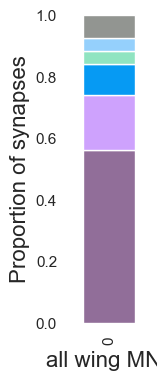

In [10]:
# plot for all wing MNs combined
source = pd.DataFrame(df_total).T

#create stacked bar chart
p = source.plot(kind='bar', stacked=True, width = 1, legend = False, cmap = cmap_cell_class, figsize=(1, 4)) 

p.set_ylabel("Proportion of synapses",fontsize = 16)
p.set(ylim=(0, 1))
p.set_xlabel("all wing MNs", fontsize = 16)
plt.box(on = False)

plt.show()

In [11]:
df_total

cell_class
local                   0.561443
local_intersegmental    0.177318
descending              0.101968
sensory                 0.043088
ascending               0.041072
fragment                0.075112
dtype: float64

# cosine similarity of MNs based on preMN input

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [13]:
def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    
    return clustered_order


In [14]:
def organize_by_cos_short(map_df):
    adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])
    sim_mat_temp = cosine_similarity(adj.to_numpy().transpose())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj.iloc[:,clustered_order]
    sim_mat = cosine_similarity(reordered_df.to_numpy().transpose())
    
    return clustered_order

In [15]:
def organize_by_cos_long(map_df):
    adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])
    sim_mat_temp = cosine_similarity(adj.to_numpy())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj.iloc[clustered_order,:]
    sim_mat = cosine_similarity(reordered_df.to_numpy())
    
    
    return reordered_df

In [78]:
syn_df = pd.read_pickle('pkls/syanpse_positions_wing_v604.pkl')
syn_df.head()
adj = pd.crosstab(syn_df.pre_pt_root_id,syn_df.post_pt_root_id)
print(adj.shape)
print(multi_df.shape)

(1786, 30)
(1793, 30)


In [99]:
# first filter out PSN_u
multi_df = pd.read_pickle('pkls/preMN_to_MN_wing_v604_multi_df.pkl')
multi_df_2 = pd.read_pickle('pkls/preMN_to_MN_wing_v604_given_to_tony.pkl')

print(multi_df.shape)
if any('PSn_u' in column for column in multi_df.columns):
    # wing_premn_to_mn_df = wing_premn_to_mn_df.loc[(All,All,All,'local',All)]
    wing_premn_to_mn_df = multi_df.drop(['PSn_u'], axis=1)
    wing_premn_to_mn_df = wing_premn_to_mn_df.loc[wing_premn_to_mn_df.sum(axis=1).to_numpy()>0,:]
    print(wing_premn_to_mn_df.shape)

print(multi_df_2.shape)
if any('PSn_u' in column for column in multi_df_2.columns):
    # wing_premn_to_mn_df = wing_premn_to_mn_df.loc[(All,All,All,'local',All)]
    wing_premn_to_mn_df_2 = multi_df_2.drop(['PSn_u'], axis=1)
    wing_premn_to_mn_df_2 = wing_premn_to_mn_df_2.loc[wing_premn_to_mn_df_2.sum(axis=1).to_numpy()>0,:]
    print(wing_premn_to_mn_df_2.shape)

print(multi_df_3.shape)
if any('PSn_u' in column for column in multi_df_2.columns):
    # wing_premn_to_mn_df = wing_premn_to_mn_df.loc[(All,All,All,'local',All)]
    wing_premn_to_mn_df_2 = multi_df_2.drop(['PSn_u'], axis=1)
    wing_premn_to_mn_df_2 = wing_premn_to_mn_df_2.loc[wing_premn_to_mn_df_2.sum(axis=1).to_numpy()>0,:]
    print(wing_premn_to_mn_df_2.shape)

(1793, 30)
(1779, 29)
(1793, 30)
(1779, 29)
(1779, 29)
(1779, 29)


In [79]:
adj_cols = adj.columns.to_frame().reset_index(drop=True)
adj_cols = adj_cols.merge(properties_df,'left',left_on='post_pt_root_id',right_on='MN_id')
adj_from_xtab_df = adj.copy()
adj_from_xtab_df.columns = adj_cols['MN_label']
adj_from_xtab_df.head()
print(adj_from_xtab_df.shape)
if any('PSn_u' in column for column in adj_from_xtab_df.columns):
    # wing_premn_to_mn_df = wing_premn_to_mn_df.loc[(All,All,All,'local',All)]
    adj_from_xtab_df = adj_from_xtab_df.drop(['PSn_u'], axis=1)
    adj_from_xtab_df = adj_from_xtab_df.loc[adj_from_xtab_df.sum(axis=1).to_numpy()>0,:]
    print(adj_from_xtab_df.shape)

(1786, 30)
(1781, 29)


In [80]:
# standardize the anatomical order with new order
an_order = ['DLM_1',
 'DLM_2',
 'DLM_3',
 'DLM_4',
 'DLM_5',
 'DVM_1a',
 'DVM_1b',
 'DVM_1c',
 'DVM_2a',
 'DVM_2b',
 'DVM_3a',
 'DVM_3b',
 'PS1',
 'PS2',
 'dtpmn_u',
 'tp2',
 'tpn',
 'i1',
 'i2_u',
 'iii1',
 'iii3',
 'iii4a_u',
 'hg1_u',
 'hg2',
 'hg3',
 'hg4',
 'b1',
 'b2',
 'b3_u']

wing_premn_to_mn_df = wing_premn_to_mn_df.loc[:,an_order]
wing_premn_to_mn_df_2 = wing_premn_to_mn_df_2.loc[:,an_order]
adj_from_xtab_df = adj_from_xtab_df.loc[:,an_order]
wing_premn_to_mn_df.head()
wing_premn_to_mn_df_2.head()
adj_from_xtab_df.head()

MN_label,DLM_1,DLM_2,DLM_3,DLM_4,DLM_5,DVM_1a,DVM_1b,DVM_1c,DVM_2a,DVM_2b,...,iii1,iii3,iii4a_u,hg1_u,hg2,hg3,hg4,b1,b2,b3_u
pre_pt_root_id,,,,,,,,,,,,,,,,,,,,,
648518346459413252,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,30,8,0
648518346459520004,20,41,22,30,25,11,7,18,1,1,...,0,0,0,0,0,0,0,0,0,0
648518346459550468,13,8,9,13,6,0,0,0,0,0,...,0,0,0,1,0,0,2,0,2,0
648518346459573508,0,0,0,0,0,0,1,0,0,0,...,0,5,0,0,0,1,0,0,0,42
648518346459589380,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### From the crosstab

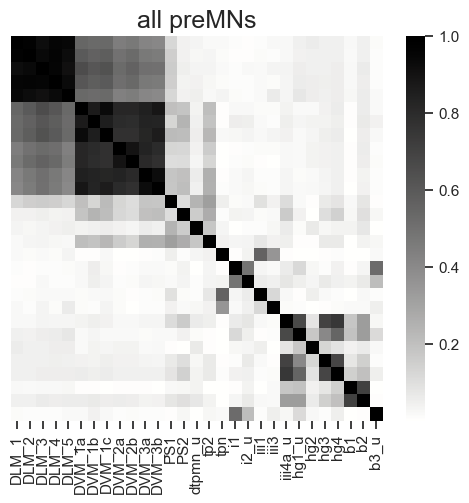

In [83]:
sim_mat = cosine_similarity(adj_from_xtab_df.to_numpy().transpose())

fig = plt.figure(1, figsize = [6,5])
cmap = cmocean.cm.gray_r
ax = sns.heatmap(sim_mat, xticklabels = adj_from_xtab_df.columns.to_list(), yticklabels = '', cmap = cmap)# xticklabels=mn_ids, cmap = cmap)
cbar = ax.collections[0].colorbar
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('', fontsize =16)
plt.title('all preMNs', fontsize = 18)

plt.show()

fig.savefig('./figpanels/cossim_anatomical_order_wing_v604_adj.svg',format='svg')
np.savetxt('./figpanels/cossim_anatomical_data_v604_adj.csv', sim_mat, delimiter=',')

### From the repo mat

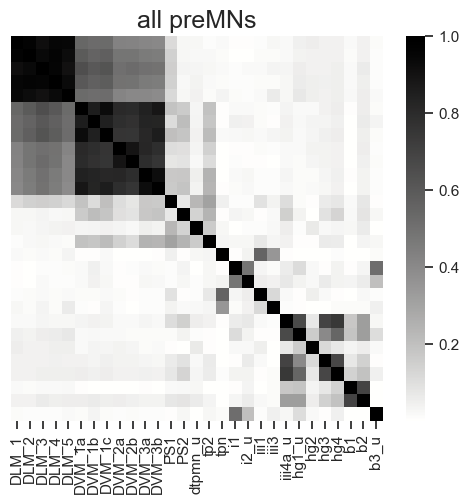

In [84]:
sim_mat = cosine_similarity(wing_premn_to_mn_df.to_numpy().transpose())

fig = plt.figure(1, figsize = [6,5])
cmap = cmocean.cm.gray_r
ax = sns.heatmap(sim_mat, xticklabels = wing_premn_to_mn_df.columns.to_list(), yticklabels = '', cmap = cmap)# xticklabels=mn_ids, cmap = cmap)
cbar = ax.collections[0].colorbar
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('', fontsize =16)
plt.title('all preMNs', fontsize = 18)

plt.show()

fig.savefig('./figpanels/cossim_anatomical_order_wing_v604_ellen.svg',format='svg')
np.savetxt('./figpanels/cossim_anatomical_data_v604_ellen.csv', sim_mat, delimiter=',')

### Given to tony

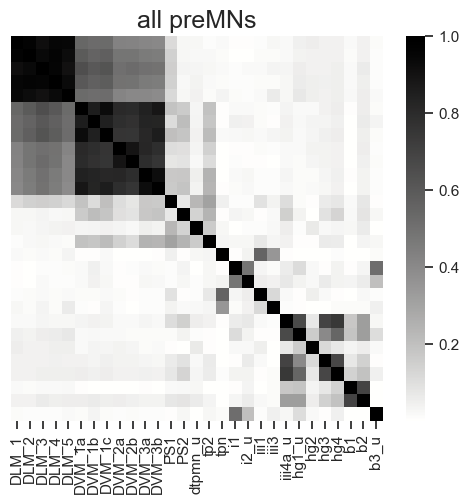

In [85]:
sim_mat_2 = cosine_similarity(wing_premn_to_mn_df_2.to_numpy().transpose())

fig = plt.figure(1, figsize = [6,5])
cmap = cmocean.cm.gray_r
ax = sns.heatmap(sim_mat_2, xticklabels = wing_premn_to_mn_df_2.columns.to_list(), yticklabels = '', cmap = cmap)# xticklabels=mn_ids, cmap = cmap)
cbar = ax.collections[0].colorbar
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('', fontsize =16)
plt.title('all preMNs', fontsize = 18)

plt.show()

fig.savefig('./figpanels/cossim_anatomical_order_wing_v604_tony.svg',format='svg')
np.savetxt('./figpanels/cossim_anatomical_data_v604_tony.csv', sim_mat_2, delimiter=',')

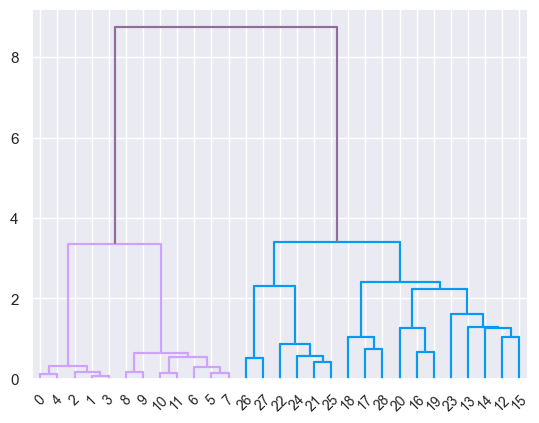

In [86]:

# clustered_order = organize_by_cos_short(syn_df)
# clustered_order = organize_by_cos_short(multi_df)

sim_mat_temp = cosine_similarity(wing_premn_to_mn_df.transpose().to_numpy())
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers

In [87]:
# adj_ordered = adj.iloc[:,clustered_order]
adj_ordered = wing_premn_to_mn_df.iloc[:,clustered_order]
adj_ordered.head()

,,,,,DLM_1,DLM_5,DLM_3,DLM_2,DLM_4,DVM_2a,DVM_2b,DVM_3a,DVM_3b,DVM_1b,...,i1,b3_u,iii3,tpn,iii1,hg2,PS2,dtpmn_u,PS1,tp2
pre_pt_root_id,preferred_module,cell_type,cell_class,putative_NT,,,,,,,,,,,,,,,,,,,,,
648518346480786912,DLM_syn,unknown,ascending,unk,36,77,61,59,49,28,9,42,41,31,...,0,0,6,0,33,0,4,0,68,7
648518346504777587,DLM_syn,unknown,ascending,unk,37,57,70,46,34,7,6,38,12,27,...,0,0,0,0,9,0,0,0,29,0
648518346472310834,DLM_syn,unknown,ascending,unk,16,18,17,17,18,3,0,3,0,28,...,0,0,0,0,0,0,0,0,3,0
648518346503916128,DLM_syn,unknown,ascending,unk,6,19,34,8,19,0,0,0,0,0,...,0,0,0,6,55,0,0,0,6,0
648518346475807714,DLM_syn,unknown,ascending,unk,8,9,14,14,6,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,0


In [88]:
dict_mn = dict(zip(properties_df.MN_id, properties_df.MN_label))
adj_ordered.rename(columns=dict_mn, inplace=True)
mn_ids = adj_ordered.columns


In [89]:
adj_ordered

,,,,,DLM_1,DLM_5,DLM_3,DLM_2,DLM_4,DVM_2a,DVM_2b,DVM_3a,DVM_3b,DVM_1b,...,i1,b3_u,iii3,tpn,iii1,hg2,PS2,dtpmn_u,PS1,tp2
pre_pt_root_id,preferred_module,cell_type,cell_class,putative_NT,,,,,,,,,,,,,,,,,,,,,
648518346480786912,DLM_syn,unknown,ascending,unk,36,77,61,59,49,28,9,42,41,31,...,0,0,6,0,33,0,4,0,68,7
648518346504777587,DLM_syn,unknown,ascending,unk,37,57,70,46,34,7,6,38,12,27,...,0,0,0,0,9,0,0,0,29,0
648518346472310834,DLM_syn,unknown,ascending,unk,16,18,17,17,18,3,0,3,0,28,...,0,0,0,0,0,0,0,0,3,0
648518346503916128,DLM_syn,unknown,ascending,unk,6,19,34,8,19,0,0,0,0,0,...,0,0,0,6,55,0,0,0,6,0
648518346475807714,DLM_syn,unknown,ascending,unk,8,9,14,14,6,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648518346493928590,steerD_syn,19B,local,ACh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648518346491927314,steerD_syn,3B,local,GABA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648518346494724853,steerD_syn,11B,local,GABA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


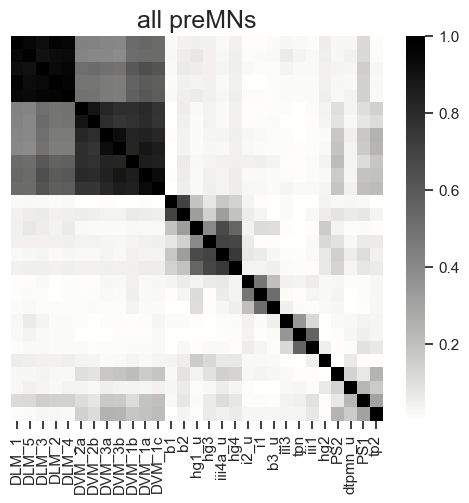

In [90]:
sim_mat = cosine_similarity(adj_ordered.to_numpy().transpose())

fig = plt.figure(1, figsize = [6,5])
cmap = cmocean.cm.gray_r
ax = sns.heatmap(sim_mat, xticklabels = mn_ids, yticklabels = '', cmap = cmap)# xticklabels=mn_ids, cmap = cmap)
cbar = ax.collections[0].colorbar
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('', fontsize =16)
plt.title('all preMNs', fontsize = 18)

plt.show()

fig.savefig('./figpanels/cossim_hierarchical_clustering_wing.svg',format='svg')
np.savetxt('./figpanels/cossim_anatomical_data.csv', sim_mat, delimiter=',')

In [31]:
# plot distributions of module preference according to cell class 
# need to create a dataframe where each row contains a unique preMN ID, its cell class, and the fraction of its output onto a single motor cluster, and total # of MN synapses

In [42]:
# motor clusters
cluster_dict = {
"DLM_clu" : ['DLM_1','DLM_2','DLM_3','DLM_4','DLM_5'],
"DVM_clu" : ['DVM_1a','DVM_1b','DVM_1c','DVM_2a','DVM_2b','DVM_3a','DVM_3b'],
"tension_clu" : ['PS1','PS2','dtpmn_u','tp2'],
"steerA_clu" : ['tpn','iii1','iii3'],
"steerB_clu" : ['i2_u','i1','b3_u'],
"steerC_clu" : ['b2','b1'],
"hg2_clu" : ['hg2'],
"steerD_clu" : ['hg1_u','hg3','hg4','iii4a_u']
}
flat_dict = {val:key for key, lst in cluster_dict.items() for val in lst}

In [48]:
properties_df['cluster'] = properties_df.MN_label.map(flat_dict)
properties_df = properties_df.rename(columns={'MN_id':'post_pt_root_id'})

In [51]:
syn_df = syn_df.merge(properties_df[['post_pt_root_id','cluster']])

In [59]:
adj = pd.crosstab(syn_df.pre_pt_root_id,syn_df.cluster)
adj.head()

cluster,DLM_clu,DVM_clu,hg2_clu,steerA_clu,steerB_clu,steerC_clu,steerD_clu,tension_clu
pre_pt_root_id,,,,,,,,
648518346459413252,0,0,0,1,0,38,0,0
648518346459520004,138,72,0,0,0,0,0,38
648518346459550468,49,0,0,0,0,2,3,0
648518346459573508,0,1,0,5,84,0,1,1
648518346459589380,1,0,0,0,27,0,1,0


In [75]:
pref_df = pd.DataFrame(adj.sum(axis=1).reset_index(name='MN_syn'))
pref_df = pref_df.merge(pd.DataFrame(adj.max(axis=1).reset_index(name='top_syn')))
pref_df['proportion'] = pref_df.top_syn / pref_df.MN_syn
pref_df = pref_df.merge(multi_df.reset_index()[['pre_pt_root_id','cell_class']])

pref_df['log_syn'] = np.log(pref_df['MN_syn'])
pref_df['syn_bin'] = pd.cut(pref_df.log_syn,10) # bin number of MN synapses for plotting by hue

pref_df.head()

,pre_pt_root_id,MN_syn,top_syn,proportion,cell_class,log_syn,syn_bin
0,648518346459413252,39,38,0.974359,local,3.663562,"(2.955, 3.693]"
1,648518346459520004,248,138,0.556452,descending,5.513429,"(5.171, 5.909]"
2,648518346459550468,54,49,0.907407,local,3.988984,"(3.693, 4.432]"
3,648518346459573508,92,84,0.913043,local,4.521789,"(4.432, 5.171]"
4,648518346459589380,29,27,0.931034,local,3.367296,"(2.955, 3.693]"


/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenlesser/

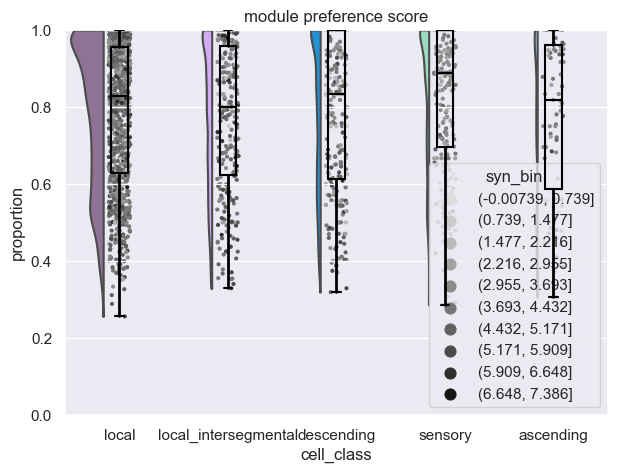

In [78]:
ort = 'v' # vertical or horizontally oriented plot
dx = "cell_class"
dy = "proportion"
class_order = ['local', 'local_intersegmental','descending','sensory','ascending']
plot_df = pref_df

pal = sns.color_palette("Greys", n_colors=12)
pal = pal[2:]

f, ax = plt.subplots(figsize=(7, 5))

ax=pt.half_violinplot( x = dx, y = dy, data = plot_df, bw = .2, cut = 0.,
scale = "count", width = .6, inner = None, orient = ort, order=class_order)

ax=sns.stripplot( x = dx, y = dy, data = plot_df, hue="syn_bin", palette = pal,
size = 3, jitter = 1, zorder = 0, orient = ort, order=class_order) # edgecolor = "white"

ax=sns.boxplot( x = dx, y = dy, data = plot_df, color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort, order=class_order)
plt.ylim(0,1)
plt.title("module preference score")
plt.show()